### Packages Needed

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy import stats

### Calculate R/P Index for each year and watershed

In [4]:
#watersheds
Watersheds=['Spius','Chilko','Chilcotin','Nation','Osilinka','Mesilinka','Stellako','Nautley']

#initiate result dataframes
Results_Diff=pd.DataFrame(); Results_Summer=pd.DataFrame(); Results_Fall=pd.DataFrame(); Results_Spring=pd.DataFrame()

#loop through watersheds
for WS in Watersheds:
    
    #read in climate data
    Precip_TB= pd.read_excel('D:/UNBC/HydroMet_Project/Data/ERA5_land/Summary_ERA5_land_Monthly.xlsx', sheet_name=WS)

    Precip=[];Runoff=[];Precip_S=[];Runoff_S=[];Precip_Sp=[];Runoff_Sp=[];Precip_F=[];Runoff_F=[]
    
    #loop through years
    for year in np.arange(1982,2020):
        
        #not all watersheds had 2019 data;places NaN in watersheds with no 2019 data
        if year ==2019:
            if WS in ['Spius','Chilko','Nation','Osilinka','Mesilinka']:
                Precip.append(np.nan); Runoff.append(np.nan)
                Precip_S.append(np.nan); Runoff_S.append(np.nan)
                Precip_Sp.append(np.nan); Runoff_Sp.append(np.nan)
                Precip_F.append(np.nan); Runoff_F.append(np.nan)
                continue
         
        #calculates water year precip and runoff arrays
        Precip.append(np.sum(Precip_TB[((Precip_TB.Year==year) & (Precip_TB.Month<10))|
                                       ((Precip_TB.Year==year-1) & (Precip_TB.Month>=10))]['Avg Precip']))
        Runoff.append(np.sum(Precip_TB[((Precip_TB.Year==year) & (Precip_TB.Month<10))|
                                       ((Precip_TB.Year==year-1) & (Precip_TB.Month>=10))]['Discharge_obs']))
        
        #calculates fall precip and runoff
        Precip_F.append(np.sum(Precip_TB[(Precip_TB.Year==year) & ((Precip_TB.Month==9)|(Precip_TB.Month==10)|
                                                                  (Precip_TB.Month==11))]['Avg Precip']))
        Runoff_F.append(np.sum(Precip_TB[(Precip_TB.Year==year) & ((Precip_TB.Month==9)|(Precip_TB.Month==10)|
                                                                  (Precip_TB.Month==11))]['Discharge_obs']))
        
        #calculates spring precip and runoff
        Precip_Sp.append(np.sum(Precip_TB[(Precip_TB.Year==year) & ((Precip_TB.Month==3)|(Precip_TB.Month==4)|
                                                                  (Precip_TB.Month==5))]['Avg Precip']))
        Runoff_Sp.append(np.sum(Precip_TB[(Precip_TB.Year==year) & ((Precip_TB.Month==3)|(Precip_TB.Month==4)|
                                                                  (Precip_TB.Month==5))]['Discharge_obs']))
        
        #calculates summer precip and runoff
        Precip_S.append(np.sum(Precip_TB[(Precip_TB.Year==year) & ((Precip_TB.Month==6)|(Precip_TB.Month==7)|
                                                                  (Precip_TB.Month==8))]['Avg Precip']))
        Runoff_S.append(np.sum(Precip_TB[(Precip_TB.Year==year) & ((Precip_TB.Month==6)|(Precip_TB.Month==7)|
                                                                  (Precip_TB.Month==8))]['Discharge_obs']))
    #change all lists to arrays
    Precip=np.array(Precip); Runoff=np.array(Runoff)
    Precip_S=np.array(Precip_S); Runoff_S=np.array(Runoff_S)
    Precip_Sp=np.array(Precip_Sp); Runoff_S=np.array(Runoff_Sp)
    Precip_F=np.array(Precip_F); Runoff_S=np.array(Runoff_F)

    #calculates normalized R/P index for each year for annual,  spring, summer, and fall
    Diff_Index= ((Runoff/Precip)-np.nanmean(Runoff/Precip))/np.nanstd(Runoff/Precip)
    Sum_Index= ((Runoff_S/Precip_S)-np.nanmean(Runoff_S/Precip_S))/np.nanstd(Runoff_S/Precip_S)
    Fall_Index= ((Runoff_F/Precip_F)-np.nanmean(Runoff_F/Precip_F))/np.nanstd(Runoff_F/Precip_F)
    Sp_Index= ((Runoff_Sp/Precip_Sp)-np.nanmean(Runoff_Sp/Precip_Sp))/np.nanstd(Runoff_Sp/Precip_Sp)


    #save the R/P indicies in a dataframe
    Results_Diff= Results_Diff.append({'WS':WS,'Year':np.arange(1982,2020),'Run-Precip_IDX':Diff_Index},ignore_index=True)
    Results_Summer=Results_Summer.append({'WS':WS,'Year':np.arange(1982,2020),'Run-Precip_IDX':Sum_Index},ignore_index=True)
    Results_Fall=Results_Fall.append({'WS':WS,'Year':np.arange(1982,2020),'Run-Precip_IDX':Fall_Index},ignore_index=True)
    Results_Spring=Results_Spring.append({'WS':WS,'Year':np.arange(1982,2020),'Run-Precip_IDX':Sp_Index},ignore_index=True)

### Defining MPB outbreaks and years of low logging/forest fire events

In [8]:
#path to MPB data
path='D:/UNBC/HydroMet_Project/Data/Forest_Disturbance/'

#watersheds
watersheds=['Spius','Chilko','Chilcotin','Nation','Osilinka','Mesilinka','Stellako','Nautley']

year_range=pd.DataFrame()

#loop through watersheds
for count, WS in enumerate(watersheds):
    
    #extract ECA data (logging, MPB, and Fire)
    ECA=pd.read_excel(path+'ECA.xlsx',sheet_name=WS)
    Logging= ECA[ECA.Year>1980].Logging.values
    MPB= ECA[ECA.Year>1980]['MPB_NEW'].values
    Fire= ECA[ECA.Year>1980]['Fire_NEW'].values
        
    #define changes in MPB,logging, and fire between each year
    Delta_MPB=[];Delta_Logging=[];Delta_Fire=[]
    for i in np.arange(0,len(MPB)):
        Delta_MPB.append(MPB[i]-MPB[i-1])
        Delta_Logging.append(Logging[i]-Logging[i-1])
        Delta_Fire.append(Fire[i]-Fire[i-1])
    
    #define where MPB ECA change is greater than 0.4%
    ix= np.where(np.array(Delta_MPB)>0.4)[0]
    
    #Idenfies year where MPB outbreak starts
    MPB_Start=np.arange(1981,2019)[ix[0]]
    
    j=0 # stopping point variable
    add=1
    while j==0:
        
        #determine time period where Logging and fire ECA do not exceed 3% change and span before and after MPB outbreak began
        L=ECA[(ECA.Year>=MPB_Start-add)&(ECA.Year<=MPB_Start+add)].Logging.values
        F=ECA[(ECA.Year>=MPB_Start-add)&(ECA.Year<=MPB_Start+add)].Fire_NEW.values
        
        #if ECA change is less than three percent in both Forest fires and logging, add 1 more year to timespand
        if (abs(max(L)-min(L)) <3) &(abs(max(F)-min(F))<3):
            add=add+1
            
        #if other distrubances is greater than 3%, record MPB start and how many years before and after outbreak has low 
        # other dirrtubance types
        else:
            year_range=year_range.append({'WS':WS,'Add':add, 'Start':MPB_Start},ignore_index=True)
            j=1 #break point of loop

year_range

,Add,Start,WS
0,7.0,2004.0,Spius
1,5.0,2004.0,Chilko
2,5.0,2004.0,Chilcotin
3,7.0,2005.0,Nation
4,8.0,2006.0,Osilinka
5,9.0,2005.0,Mesilinka
6,4.0,2008.0,Stellako
7,3.0,2008.0,Nautley


###  Runoff and MPB analysis

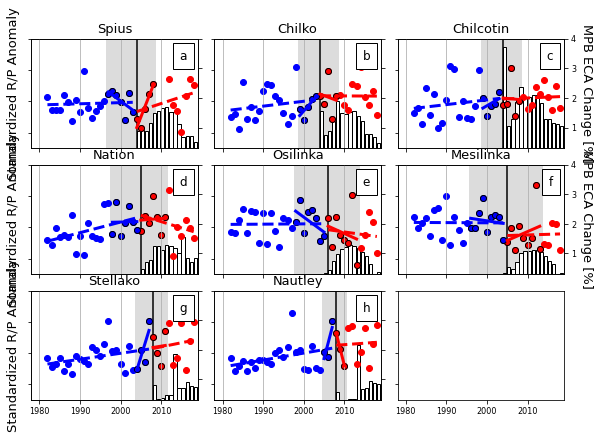

In [11]:
#watersheds
Watersheds=['Spius','Chilko','Chilcotin','Nation','Osilinka','Mesilinka','Stellako','Nautley']


#-----------------------------initilize plotting--------------------------------------  
def cm2inch(*tupl):### plots in cm 
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
fig,ax=plt.subplots(3,3,figsize=cm2inch(20,15),sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.1, top=0.95, hspace=0.15, left=0.05, right=0.99, wspace=0.1)

font = {'family' : 'sans-serif', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)

xi=[0,0,0,1,1,1,2,2,2]
yi=[0,1,2,0,1,2,0,1,2]
L=['a','b','c','d','e','f','g','h']

#------------------------------------- Analysis-------------------------------------------

#initilize DataFrames
Results=pd.DataFrame()
Results_ALL=pd.DataFrame()

#loop through watersheds
for count, WS in enumerate(Watersheds):
    
    # read in climate data
    Precip_TB= pd.read_excel('D:/UNBC/HydroMet_Project/Data/ERA5_land/Summary_ERA5_land_Monthly.xlsx', sheet_name=WS)

    #initilize arrays
    Precip=[];Runoff=[]
    
    #loop through years
    for year in np.arange(1982,2020):
        
        #some waterhseds don't have 2019 data, so it is replaced with NAN
        if year ==2019:
            if WS in ['Spius','Chilko','Nation','Osilinka','Mesilinka']:
                Precip.append(np.nan); Runoff.append(np.nan)
                Precip_S.append(np.nan); Runoff_S.append(np.nan)
                Precip_Sp.append(np.nan); Runoff_Sp.append(np.nan)
                Precip_F.append(np.nan); Runoff_F.append(np.nan)
                continue
            
        #Calculating water year precip and runoff
        Precip.append(np.sum(Precip_TB[((Precip_TB.Year==year) & (Precip_TB.Month<10))|
                                       ((Precip_TB.Year==year-1) & (Precip_TB.Month>=10))]['Avg Precip']))
        Runoff.append(np.sum(Precip_TB[((Precip_TB.Year==year) & (Precip_TB.Month<10))|
                                       ((Precip_TB.Year==year-1) & (Precip_TB.Month>=10))]['Discharge_obs']))
        
    #convert lists to arrays
    Precip=np.array(Precip); Runoff=np.array(Runoff)

    
    #R/P index for water year
    Diff_Index= ((Runoff/Precip)-np.nanmean(Runoff/Precip))/np.nanstd(Runoff/Precip)
    
    #save wateryear R?P index
    RP= pd.DataFrame({'Year':np.arange(1982,2019),'Run-Precip_IDX':Diff_Index[:-1]})
    
    #missing runoff data in Spius, remove extrapolated data from dataframe
    if WS=='Spius':
        RP=RP[(RP.Year<2009)|(RP.Year>2011)]
    
    #read  in MPB ECA data
    MPB=pd.read_excel('D:/UNBC/HydroMet_Project/Data/Forest_Disturbance/ECA.xlsx',sheet_name=WS)
    
    # extract outbreak start date and how many years to add/subtract for subsets
    Outbreak_Start=year_range[year_range.WS==WS].Start.values[0]
    Add=year_range[year_range.WS==WS].Add.values[0]
    
    #Calculating R/P for each subset (before to start of outbreak, start of outbreak to during)
    RP_before=RP[(RP.Year.values>=Outbreak_Start-Add)& (RP.Year<Outbreak_Start)]['Run-Precip_IDX'].values
    RP_during=RP[(RP.Year<Outbreak_Start+Add)&(RP.Year>=Outbreak_Start)]['Run-Precip_IDX'].values
    Year_Outbreak=MPB[(MPB.Year>1981) & (MPB.Delta_MPB>0.4)].Year.values
    
    #years before and during outbreak subsets
    Years_before=np.arange(Outbreak_Start-Add,Outbreak_Start)
    Years_during= np.arange(Outbreak_Start,Outbreak_Start+Add)
    
    #removes any years that are interpolated for Spius
    if WS=='Spius':
        if Outbreak_Start+Add>2011:
            Years_during=np.concatenate(np.arange(Outbreak_Start,2009),np.arange(2011,Outbreak_Start+Add))
        else: 
            Years_during=np.arange(Outbreak_Start,2009)
    
    #plotting before, during, before subset, and during subset
    x=xi[count];y=yi[count]
    ax[x,y].scatter(RP[RP.Year<Outbreak_Start].Year,RP[RP.Year<Outbreak_Start]['Run-Precip_IDX'], color='b')
    ax[x,y].scatter(RP[RP.Year>=Outbreak_Start].Year,RP[RP.Year>=Outbreak_Start]['Run-Precip_IDX'], color='r')
    ax[x,y].scatter(Years_during,RP_during, color='r',edgecolor='k')
    ax[x,y].scatter(Years_before,RP_before, color='b',edgecolor='k')
    
    #mean of the different periods
    Mean= np.mean(RP_during)
    Mean_prior= np.mean(RP_before)
    MeanB=np.mean(RP[RP.Year<Outbreak_Start]['Run-Precip_IDX'])
    MeanD=np.mean(RP[RP.Year>=Outbreak_Start]['Run-Precip_IDX'])
    
    #identifying standard deviation
    STD_before=np.std(RP_before)
    STD_during=np.std(RP_during)
    
    #linear reression during subset
    slope, intercept, r_value, p_value, std_err = stats.linregress(Years_during,RP_during)
    ax[x,y].plot(Years_during,slope*Years_during+intercept, color='r',label='During',linewidth=3)
    
    #linear regression before subset
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(Years_before,RP_before)
    ax[x,y].plot(Years_before,slope2*Years_before+ intercept2, color='b',label='Prior',linewidth=3)
    
    #linear regression Before
    slopeB, interceptB, r_valueB, p_valueB, std_errB = stats.linregress(RP[RP.Year<Outbreak_Start].Year,RP[RP.Year<Outbreak_Start]['Run-Precip_IDX'])
    ax[x,y].plot(RP[RP.Year<Outbreak_Start].Year,slopeB*RP[RP.Year<Outbreak_Start].Year+ interceptB, color='b',label='Prior',linewidth=3,linestyle='--')
    
    #linear regression during
    slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(RP[RP.Year>=Outbreak_Start].Year,RP[RP.Year>=Outbreak_Start]['Run-Precip_IDX'])
    ax[x,y].plot(RP[RP.Year>=Outbreak_Start].Year,slopeD*RP[RP.Year>=Outbreak_Start].Year+ interceptD, color='r',label='Prior',linewidth=3,linestyle='--')
    
    #----------------------------------plotting parameters---------------------------------
    ax[x,y].set_ylim(-3,4)
    ax[x,y].set_title(WS,size=13)
    ax[x,y].set_xlim(1978,2019)
    ax[x,y].grid(axis='x')
    
    if y==0:
        ax[x,y].set_ylabel('Standardized R/P Anomaly',size=13)
    ax1=ax[x,y].twinx()
    
    #plotting detla MPB ECA
    ax1.bar(MPB[MPB.Year>1990].Year,MPB[MPB.Year>1990].Delta_MPB,
            color='w',edgecolor='k',align='edge')
    ax1.set_ylim(.3,4)
    ax1.axvline(min(Years_during), color='k')
    
    #highlight subset area
    ax1.fill_betweenx([-3,-2,-1,0,1,2,3,4,5],min(Years_before)-0.5,max(Years_during)+.5, color='gainsboro')
    
    if y==2:
        ax1.set_ylabel('MPB ECA Change [%]',rotation=-90, labelpad=17,size=13)
    if y!=2:
        ax1.set_yticklabels([]) 
    if y!=0:
        ax[x,y].set_yticklabels([])
        
    #set bar plot behind line plot
    ax[x,y].set_zorder(1)
    ax[x,y].patch.set_visible(False)
    
    #add plot identifier
    at = AnchoredText(L[count], prop=dict(size=12), frameon=True, loc='upper right')
    at.patch.set_boxstyle("Square,pad=0.15")
    ax[x,y].add_artist(at)
    
    #save results for before and during periods
    Results_ALL=Results_ALL.append({'WS':WS,'Count':Add,'MeanB':MeanB,'MeanD':MeanD,'PB':p_valueB,'PD':p_valueD
                                    ,'Start':Outbreak_Start,'SlopeB':slopeB,'SlopeD':slopeD},ignore_index=True)
    
    #save results for before and during SUBSET periods
    Results=Results.append({'WS':WS,'Count':Add,'MeanB':Mean_prior,'MeanD':Mean,'PB':p_value2,'PD':p_value,'SDB':STD_before,
                           'SDD':STD_during,'Start':Outbreak_Start,'SlopeB':slope2,'SlopeD':slope},ignore_index=True)
    
 
# Save figure
Path_Figs='C:/Users/margo.DESKTOP-T66VM01/Desktop/UNBC/Writting_Drafts/Manuscripts_for_submission/Figures/'
# fig.savefig(Path_Figs+'Figure6.eps',dpi=700)

In [12]:
Results

,Count,MeanB,MeanD,PB,PD,SDB,SDD,SlopeB,SlopeD,Start,WS
0,7.0,0.020273,-0.343024,0.165218,0.027939,0.658922,1.025591,-0.193637,0.665590,2004.0,Spius
1,5.0,-0.320209,0.266001,0.128369,0.822783,0.544171,1.006443,0.295991,-0.099377,2004.0,Chilko
2,5.0,-0.133447,0.157688,0.482264,0.957739,0.509439,1.034536,0.151028,-0.024285,2004.0,Chilcotin
3,7.0,0.337911,0.516195,0.972920,0.907001,0.790861,0.740823,0.006309,0.020322,2005.0,Nation
4,8.0,0.359566,-0.341077,0.186293,0.622466,0.844209,1.297037,-0.191668,-0.117294,2006.0,Osilinka
5,9.0,0.409763,-0.390686,0.724408,0.529540,0.748147,1.208561,-0.039820,0.113512,2005.0,Mesilinka
6,4.0,0.183565,0.428469,0.193758,0.945642,1.171986,0.869884,0.845148,0.042293,2008.0,Stellako
7,3.0,0.648545,0.243304,0.420010,0.014973,1.027485,0.841244,0.994324,-1.030025,2008.0,Nautley


In [49]:
Results_ALL

,Count,MeanB,MeanD,PB,PD,SlopeB,SlopeD,Start,WS
0,7.0,-0.141406,-0.035252,0.779029,0.242231,0.007241,0.086008,2004.0,Spius
1,5.0,-0.232958,0.341671,0.370557,0.981405,0.031245,-0.001397,2004.0,Chilko
2,5.0,-0.137182,0.222015,0.441398,0.832032,0.030328,0.011054,2004.0,Chilcotin
3,7.0,-0.145143,0.238449,0.022060,0.272035,0.068101,-0.080714,2005.0,Nation
4,8.0,0.203122,-0.374995,0.942020,0.710971,0.001845,-0.036093,2006.0,Osilinka
5,9.0,0.292263,-0.480146,0.962111,0.920959,-0.001313,0.007745,2005.0,Mesilinka
6,4.0,-0.216024,0.563052,0.091166,0.668532,0.038244,0.052531,2008.0,Stellako
7,3.0,-0.238905,0.601079,0.058791,0.865444,0.044552,0.018988,2008.0,Nautley
